<h1> 1. Exploring natality dataset </h1>

This notebook illustrates:
<ol>
<li> Exploring a BigQuery dataset using Datalab
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-ebb596f9b0afaeab'   # CHANGE this to a globally unique value. Your project name is a good option to try.
PROJECT = 'qwiklabs-gcp-ebb596f9b0afaeab'     # CHANGE this to your project name
REGION = 'us-central1'               # CHANGE this to one of the regions supported by Cloud AI Platform https://cloud.google.com/ml-engine/docs/tensorflow/regions

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [ ]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Explore data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

In [3]:
# Create SQL query using natality data after the year 2000
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [4]:
# Call BigQuery and examine in dataframe
from google.cloud import bigquery
df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,6.999677,False,33,1,38.0,2126480030009879160
1,6.768191,False,22,1,36.0,8904940584331855459
2,7.625790,False,32,1,41.0,2126480030009879160
3,6.563162,True,30,1,40.0,7146494315947640619
4,6.563162,False,35,1,37.0,5896567601480310696


## Lab Task #1
Using the above code as an example, write a query to find the unique values for each of the columns and the count of those values for babies born after the year 2000.
For example, we want to get these values:
<pre>
is_male	num_babies	avg_wt
False	16245054	7.104715
 True	17026860	7.349797
</pre>
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [20]:
query = """
SELECT
    is_male,
    COUNT(1) as num_babies,
    AVG(weight_pounds) AS avg_wt
FROM
    publicdata.samples.natality
WHERE 
    year > 2000
GROUP BY 
    is_male
"""

df = bigquery.Client().query(query).to_dataframe()
df.head()


,is_male,num_babies,avg_wt
0,False,16245054,7.104715
1,True,17026860,7.349797


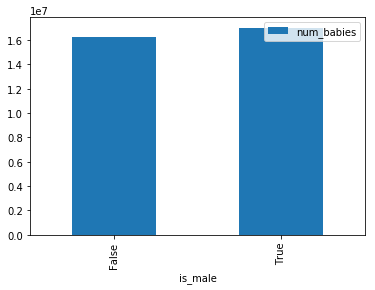

In [23]:
df.plot.bar(y='num_babies', x='is_male')

## Gestation Weels

In [24]:
query = """
SELECT
    gestation_weeks,
    COUNT(1) as num_babies,
    AVG(weight_pounds) AS avg_wt
FROM
    publicdata.samples.natality
WHERE 
    year > 2000
GROUP BY 
    gestation_weeks
"""
df = bigquery.Client().query(query).to_dataframe()
df.head()

,gestation_weeks,num_babies,avg_wt
0,33.0,310675,5.285956
1,41.0,2993797,7.786118
2,47.0,43895,7.496152
3,32.0,208791,4.907616
4,36.0,1524448,6.437536


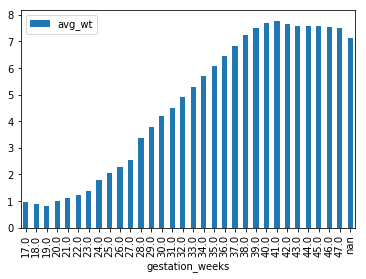

In [27]:
df = df.sort_values(by='gestation_weeks', ascending=True)
df.plot.bar(y='avg_wt', x='gestation_weeks')

## Mother Age

In [29]:
query = """
SELECT
    mother_age,
    COUNT(1) as num_babies,
    AVG(weight_pounds) AS avg_wt
FROM
    publicdata.samples.natality
WHERE 
    year > 2000
GROUP BY 
    mother_age
"""
df = bigquery.Client().query(query).to_dataframe()
df = df.sort_values(by="mother_age")
df.head()

,mother_age,num_babies,avg_wt
44,10,3,7.533195
36,11,44,6.149945
4,12,1196,6.506330
11,13,7552,6.656063
27,14,44868,6.743684


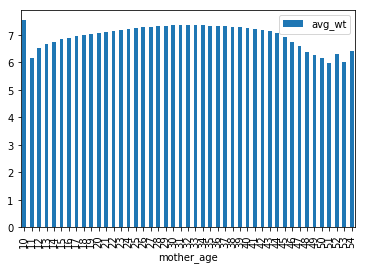

In [30]:
df.plot.bar(y='avg_wt', x='mother_age')

## Twins

In [31]:
query = """
SELECT
    plurality,
    COUNT(1) as num_babies,
    AVG(weight_pounds) AS avg_wt
FROM
    publicdata.samples.natality
WHERE 
    year > 2000
GROUP BY 
    plurality
"""
df = bigquery.Client().query(query).to_dataframe()
df = df.sort_values(by="plurality")
df.head()

,plurality,num_babies,avg_wt
0,1,32159762,7.304663
3,2,1056305,5.144866
2,3,51913,3.688442
1,4,3337,2.848459
4,5,597,2.515053


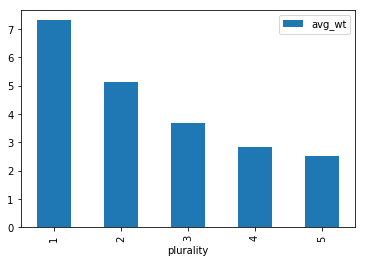

In [32]:
df.plot.bar(y='avg_wt', x='plurality')

## Lab Task #1
Using the above code as an example, write a query to find the unique values for each of the columns and the count of those values for babies born after the year 2000.
For example, we want to get these values:
<pre>
is_male	num_babies	avg_wt
False	16245054	7.104715
 True	17026860	7.349797
</pre>
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

Hint (highlight to see): <p style='color:white'>Use COUNT(), AVG() and GROUP BY. For example:
<pre style='color:white'>
SELECT
  is_male,
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  is_male
</pre>
</p>

## Lab Task #2

Which factors seem to play a part in the baby's weight?

<b>Bonus:</b> Draw graphs to illustrate your conclusions

Hint (highlight to see): <p style='color:white'> The simplest way to plot is to use Pandas' built-in plotting capability
<pre style='color:white'>
from google.cloud import bigquery
df = bigquery.Client().query(query).to_dataframe()
df.plot(x='is_male', y='num_babies', logy=True, kind='bar');
df.plot(x='is_male', y='avg_wt', kind='bar');
</pre>

Copyright 2017-2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License